# Imports

In [1]:
%matplotlib inline
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt

# Camera Calibration

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

imgs = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(imgs):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite('camera_cal/chessboard_cal/' + write_name, img)

In [3]:
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   img_size, 
                                                   None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, 
            open( "camera_cal/wide_dist_pickle.p", "wb" ))

# Image Detail Extraction

In [4]:
def get_sobel_binary(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x, y = (1, 0) if orient == 'x' else (0, 1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sobel_binary

def get_hls_binary(img, thresh_min=200, thresh_max=255, channel=2):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    channel = hls[:,:,channel]
    hls_binary = np.zeros_like(channel)
    hls_binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    return hls_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [98]:
img = cv2.imread('test_images/straight_lines1.jpg')

In [99]:
img = cv2.undistort(img, mtx, dist, None, mtx)

sobelx_binary = get_sobel_binary(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                                 thresh_min=30, thresh_max=255)
sobely_binary = get_sobel_binary(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                                 orient='y', thresh_min=3, thresh_max=70)
hls_binary = get_hls_binary(img, thresh_min=150, thresh_max=255)

combined_binary = np.zeros_like(sobelx_binary)
combined_binary[(hls_binary == 1) | (sobelx_binary == 1)] = 1
combined_binary[(sobely_binary == 0)] = 0

src = np.float32([(270, 670),
                  (560, 475),
                  (720, 475),
                  (1020, 670)])

dst = np.float32([(270, 670),
                  (270, 475),
                  (1020, 475),
                  (1020, 670)])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (img.shape[1], img.shape[0])
# combined_binary = cv2.undistort(combined_binary, mtx, dist, None, mtx)
binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
# plt.imshow(undst_img, cmap="gray")

# Line Finding

In [100]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit, right_fit)

[ -7.73073176e-06   1.78135530e-02   2.71334939e+02] [ -8.05364911e-05   3.82413029e-02   1.03779668e+03]


(720, 0)

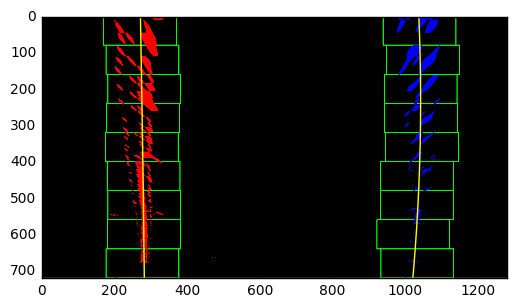

In [86]:
# # Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [89]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                               left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                  (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                               left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
                                right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                   (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

(720, 0)

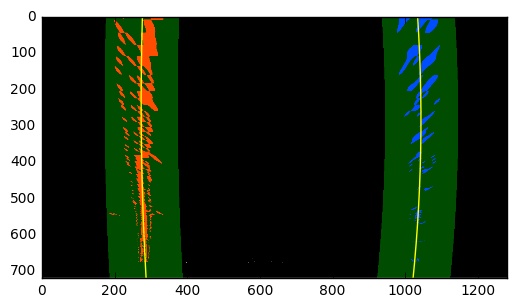

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

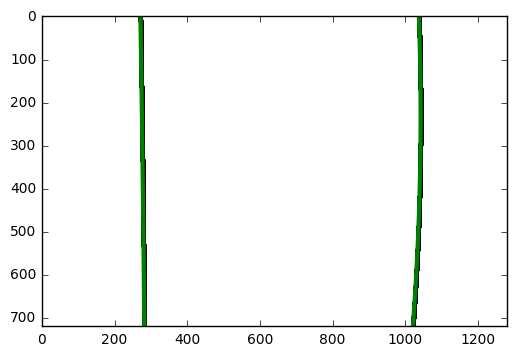

In [90]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
leftx = fit_leftx
rightx = fit_rightx

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [92]:
y_eval = np.max(ploty)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                       left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                        right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

# Get meters off road center
screen_middel_pixel = img.shape[1]/2
left_lane_pixel = left_fitx[-1]
right_lane_pixel = right_fitx[-1]
car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
screen_off_center = screen_middel_pixel - car_middle_pixel
meters_off_center = xm_per_pix * screen_off_center
print(meters_off_center)

28057.6208702 m 1820.31354655 m
-0.05814285714285715


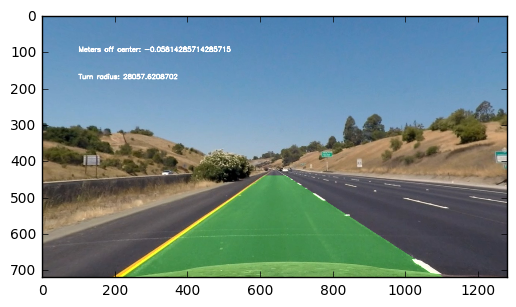

In [93]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

# Combine the result with the original image
undst_img0 = cv2.undistort(img, mtx, dist, None, mtx)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(undst_img0, "Meters off center: " + str(meters_off_center), 
            (100,100), font, .6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(undst_img0, "Turn radius: " + str(left_curverad), 
            (100,175), font, .6,(255,255,255),2,cv2.LINE_AA)
result = cv2.addWeighted(undst_img0, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [103]:
def process_image(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    sobelx_binary = get_sobel_binary(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                                     thresh_min=30, thresh_max=255)
    sobely_binary = get_sobel_binary(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 
                                     orient='y', thresh_min=3, thresh_max=70)
    hls_binary = get_hls_binary(img, thresh_min=150, thresh_max=255)

    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(hls_binary == 1) | (sobelx_binary == 1)] = 1
    combined_binary[(sobely_binary == 0)] = 0

    src = np.float32([(270, 670),
                      (560, 475),
                      (720, 475),
                      (1020, 670)])

    dst = np.float32([(270, 670),
                      (270, 475),
                      (1020, 475),
                      (1020, 670)])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
#     undst_img = cv2.undistort(combined_binary, mtx, dist, None, mtx)
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    global left_fit
    global right_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + 
                                   left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                                   left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + 
                                    right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                    right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    leftx = fit_leftx
    rightx = fit_rightx

    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    screen_middel_pixel = img.shape[1]/2
    left_lane_pixel = left_fitx[-1]
    right_lane_pixel = right_fitx[-1]
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image

    undst_img0 = cv2.undistort(img, mtx, dist, None, mtx)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(undst_img0, "Meters off center: " + str(meters_off_center), 
                (100,100), font, .6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(undst_img0, "Turn radius: " + str(left_curverad), 
                (100,175), font, .6,(255,255,255),2,cv2.LINE_AA)
    result = cv2.addWeighted(undst_img0, 1, newwarp, 0.3, 0)
    return result

In [16]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [104]:
results = 'results.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(results, audio=False)

[MoviePy] >>>> Building video results.mp4
[MoviePy] Writing video results.mp4


100%|█████████▉| 1260/1261 [02:31<00:00,  8.65it/s]    | 1/1261 [00:00<02:18,  9.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results.mp4 

CPU times: user 17min 59s, sys: 6.13 s, total: 18min 6s
Wall time: 2min 31s


In [18]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(results))

In [9]:
tests = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(tests):
    img = cv2.imread(fname)
    new_img = process_image(img)
    cv2.imwrite('output_images/' + fname[12:], new_img)